In [1]:
import pandas as pd
import numpy as np
import pylab as plt
import scipy.optimize as op
from datetime import datetime

import os
from pandas.tseries.offsets import BDay

## a) Loading the return series

In [2]:
ret_file = os.path.join('MFE_DAM', 'Data', 'US.csv')
us_df = pd.read_csv(ret_file, parse_dates=[0], index_col=[0], na_values=[0])
us_df = us_df.fillna(method='ffill')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001D9552F1B38>,
      dtype=object)

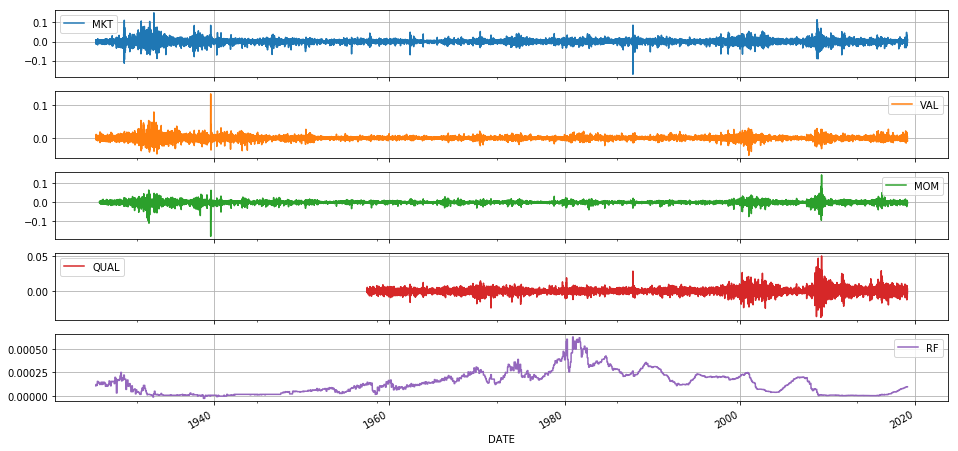

In [3]:
us_df.plot(figsize=(16,8), grid=True, subplots=True)

## b) Functions definition

In [4]:
def convertIR2Weights(ir_df, day_lag = 0):
    """
    Function to calculate the factor weights from the IR series.
    The frequency is the same as ir_df
    """
    # omit Rf bond because its w is too small
    df = ir_df.drop(columns=['RF'], inplace=False)
    
    weights = pd.DataFrame(columns = df.columns, index = df.index)
    tmp_Sum = df.sum(axis=1)
    for col in weights.columns:
        weights[col] = df[col]/tmp_Sum
    weights.fillna(0, inplace=True)
    weights.index = weights.index + BDay(day_lag)
    return weights

In [6]:
def weights2Daily(weights, idx):
    """
    Change the weights frequency into daily basis
    Forward fill the inbetween elements
    """
    weights_daily = pd.DataFrame(index = idx)
    for col in weights.columns:
        weights_daily[col] = weights[col]
    weights_daily.fillna(method='ffill',inplace=True)
    return weights_daily

In [47]:
def calc_Tcost(ir_df, weights, tcost_vec):
    """
    Assume the strategy rebalanced at the same frequency as ir_df
    Calculate the trading cost
    """
    ret = 1+ir_df
    ret['Group'] = np.nan
    # ret.loc[weights.index, 'Group'] = np.array(range(1,weights.shape[0]+1))
    ret['Group'] = pd.Series(range(1,weights.shape[0]+1), index=weights.index)
    ret['Group'].fillna(method='ffill', inplace=True)
    ret['Group'].fillna(0, inplace=True)
    ret_yearly = ret.groupby(['Group']).prod()
    ret_yearly.drop(ret_yearly.index[0], axis=0, inplace=True)
    
    ret_yearly.index = weights.index
    ret_yearly[ret_yearly==1.] = np.nan
    ret_yearly = ret_yearly.reindex(columns=weights.columns)
    tmp_port = weights*ret_yearly.values
    tmp_Sum = tmp_port.sum(axis=1)
    
    w_wo_rebalance = pd.DataFrame(columns = weights.columns, index = weights.index)
    for col in weights.columns:
        w_wo_rebalance[col] = tmp_port[col]/tmp_Sum
    w_wo_rebalance = w_wo_rebalance.shift(1)
    w_wo_rebalance.iloc[0] = weights.iloc[0]
    w_abs_diff = weights.subtract(w_wo_rebalance, fill_value=0).abs()
    Tcost = w_abs_diff.dot(tcost_vec)
    return Tcost

In [8]:
def calc_ret(ir_df, weights, weights_daily, tcost_vec):
    """
    Taking into account the trading cost, calculate the portfolio daily return series
    """
    ir_reordered = ir_df.reindex(columns=weights_daily.columns)
    tmp_df = weights_daily*ir_reordered.values
    nonNanRow = min(np.where((~tmp_df.isnull()).any(axis=1))[0])
    rets = tmp_df.sum(axis=1)
    rets.iloc[:nonNanRow] = np.nan
    
    Tcost = calc_Tcost(ir_df, weights, tcost_vec)
    rets[Tcost.index] = rets[Tcost.index] - Tcost.values
    return (rets, nonNanRow)

In [9]:
def cumul_perf(ret):
    """
    Function to calculate the cumulative excess return series
    """
    return ((1 + ret).cumprod(axis=0)) - 1

## a) Yearly IR series

In [33]:
IR_year = os.path.join('MFE_DAM', 'US_IR_wrt_mkt_year.csv')
ir_mkt_year = pd.read_csv(IR_year, parse_dates=[0], index_col=[0], na_values=[0])
ir_mkt_year = ir_mkt_year.asfreq('Y', method='ffill').fillna(method='ffill')
ir_mkt_year[ir_mkt_year<0] = 0

In [34]:
ir_mkt_year.loc[ir_mkt_year.isnull().any(axis=1)]

,MOM,QUAL,RF,VAL
1926-12-31,NaN,NaN,0.710444,0.011591
1927-12-31,0.004052,NaN,0.458107,0.000000
1928-12-31,0.004426,NaN,0.193574,0.000000
1929-12-31,0.008219,NaN,0.397795,0.005514
1930-12-31,0.005484,NaN,0.140992,0.000000
1931-12-31,0.000129,NaN,0.117255,0.000000
1932-12-31,0.000000,NaN,0.056249,0.003681
1933-12-31,0.000000,NaN,0.051433,0.001279
1934-12-31,0.003061,NaN,0.075438,0.000000
1935-12-31,0.006527,NaN,0.179379,0.000000


In [35]:
weights = convertIR2Weights(ir_mkt_year, day_lag = 1)
weights_daily = weights2Daily(weights, us_df.index)
weights

,MOM,QUAL,VAL
1927-01-03,0.000000,0.000000,1.000000
1928-01-02,1.000000,0.000000,0.000000
1929-01-01,1.000000,0.000000,0.000000
1930-01-01,0.598455,0.000000,0.401545
1931-01-01,1.000000,0.000000,0.000000
1932-01-01,1.000000,0.000000,0.000000
1933-01-02,0.000000,0.000000,1.000000
1934-01-01,0.000000,0.000000,1.000000
1935-01-01,1.000000,0.000000,0.000000
1936-01-01,1.000000,0.000000,0.000000


In [36]:
rets, nonNanRow = calc_ret(us_df, weights, weights_daily, pd.Series([50e-4]*3, index=weights.columns))
perf = cumul_perf(rets)

perf_MKT = cumul_perf(us_df.loc[us_df.index[nonNanRow]:,'MKT'])

Text(0.5,1,'Pnl Comparison')

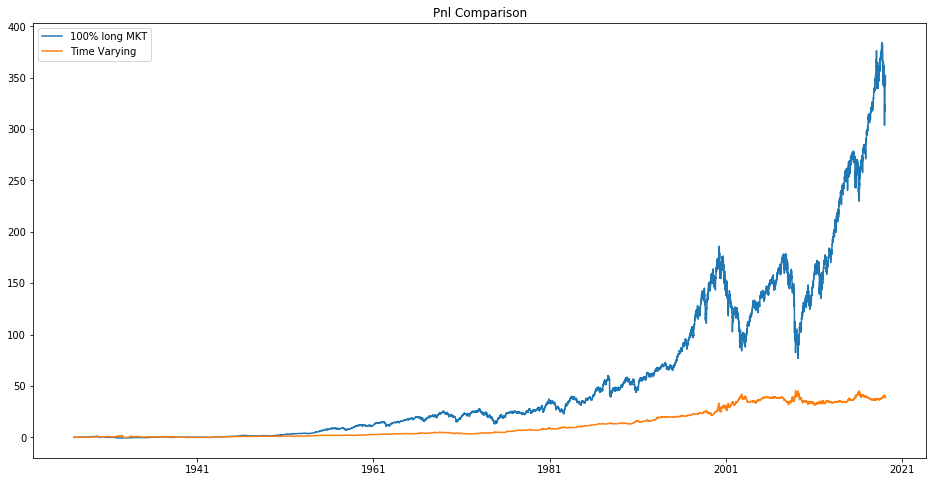

In [37]:
plt.figure('Pnl Comparison',figsize=(16,8))
plt.clf()
plt.plot(perf_MKT.index, perf_MKT.values, label='100% long MKT')
plt.plot(perf.index, perf.values, label='Time Varying')
plt.legend(loc = 'best')
plt.title('Pnl Comparison')

## Monthly IR Series

In [48]:
IR_month = os.path.join('MFE_DAM', 'US_IR_wrt_mkt_month.csv')
ir_mkt_month = pd.read_csv(IR_month, parse_dates=[0], index_col=[0], na_values=[0])
ir_mkt_month = ir_mkt_month.asfreq('M', method='ffill').fillna(method='ffill')
ir_mkt_month[ir_mkt_month<0] = 0

In [49]:
ir_mkt_month.loc[ir_mkt_month.isnull().any(axis=1)]

,MOM,QUAL,RF,VAL
1926-07-31,NaN,NaN,NaN,NaN
1926-08-31,NaN,NaN,NaN,0.095609
1926-09-30,NaN,NaN,NaN,0.000000
1926-10-31,NaN,NaN,NaN,0.041203
1926-11-30,NaN,NaN,NaN,0.011927
1926-12-31,NaN,NaN,NaN,0.000000
1927-01-31,0.081586,NaN,NaN,0.062117
1927-02-28,0.000000,NaN,NaN,0.039361
1927-03-31,0.098398,NaN,NaN,0.000000
1927-04-30,0.057460,NaN,NaN,0.008879


In [50]:
weights = convertIR2Weights(ir_mkt_month, day_lag = 1)
weights.drop(weights.index[-1], axis=0, inplace=True)
weights_daily = weights2Daily(weights, us_df.index)
weights

,MOM,QUAL,VAL
1926-08-02,0.000000,0.000000,0.000000
1926-09-01,0.000000,0.000000,1.000000
1926-10-01,0.000000,0.000000,0.000000
1926-11-01,0.000000,0.000000,1.000000
1926-12-01,0.000000,0.000000,1.000000
1927-01-03,0.000000,0.000000,0.000000
1927-02-01,0.567738,0.000000,0.432262
1927-03-01,0.000000,0.000000,1.000000
1927-04-01,1.000000,0.000000,0.000000
1927-05-02,0.866163,0.000000,0.133837


In [51]:
rets, nonNanRow = calc_ret(us_df, weights, weights_daily, pd.Series([50e-4]*3, index=weights.columns))
perf = cumul_perf(rets)

perf_MKT = cumul_perf(us_df.loc[us_df.index[nonNanRow]:,'MKT'])

Text(0.5,1,'Pnl Comparison')

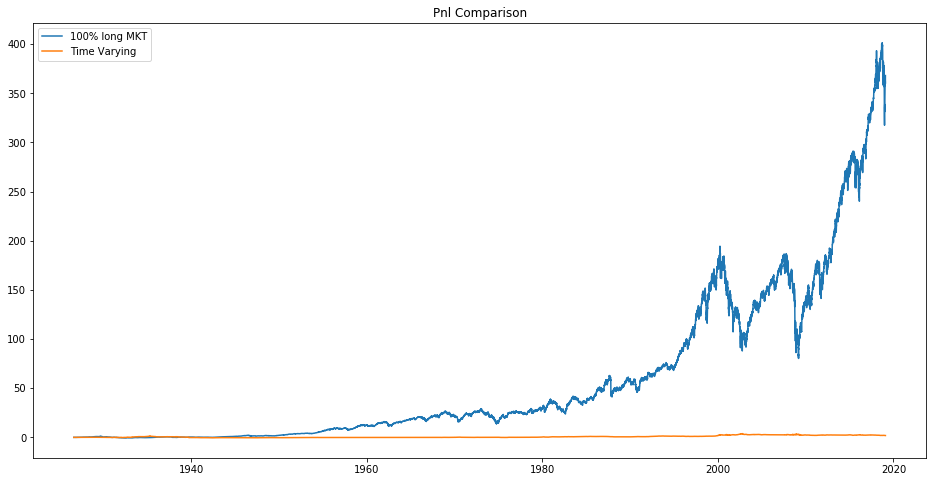

In [52]:
plt.figure('Pnl Comparison',figsize=(16,8))
plt.clf()
plt.plot(perf_MKT.index, perf_MKT.values, label='100% long MKT')
plt.plot(perf.index, perf.values, label='Time Varying')
plt.legend(loc = 'best')
plt.title('Pnl Comparison')